In [1]:
import pandas as pd
import numpy as np
import math
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import kaleido
import re
import ast
import category_encoders as ce

from IPython.display import Image

from typing import List

Задача проекта: разработать сервис для предсказания стоимости домов на основе истории предложений.
Так как нам необходимо предсказать числовое значение, то нам необходимо решить задачу регрессии.

Для начала изучим исходные данные.

In [2]:
df = pd.read_csv('data/data.csv')
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


В полученном датасете имеем следующие поля: \

status - текущий статус собственности \
private pool - наличие собственного бассейна \
property type - тип собственности \
street - улица и номер дома \
baths - количество ванных комнат \
homeFacts - дополнительная информация о собственности \
fireplace - информация о камине \
city - название города \
schools - информация о близлежащих школах \
sqft - площадь собственности \
zipcode - почтовый индекс \
beds - количество спальных мест \
state - штат \
stories - количество этажей \
mls-id - идентификационный номер члена MLS \
PrivatePool - наличие собственного бассейна \
MlsId - идентификационный номер члена MLS \
target - стоимость собственности

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [4]:
# удалим полные дубликаты строк
df = df.drop_duplicates()

В датасете достаточно много пропусков. Некоторые столбцы дублируют друг друга. \
Сначала проведем преобразование строк и выделим новые признаки.

##### Преобразуем столбец с целевым показателем.

In [5]:
# удаляем строки в которых целевой показатель отсутствует
df = df.drop(df[df['target'].isna()].index)

In [6]:
# найдем все строки в которых целевой показатель не является числом
df[~df['target'].str.isnumeric()]['target']

0           $418,000
1           $310,000
2         $2,895,000
3         $2,395,000
4             $5,000
             ...    
377180    $1,249,000
377181      $674,999
377182      $528,000
377183       $34,500
377184      $204,900
Name: target, Length: 374642, dtype: object

In [7]:
# уберем знак долара и запятую из целевого показателя для того, чтобы можно было его
# преобразовать
df['target'] = df['target'].apply(lambda target: target.replace('$', '')\
                                                       .replace(',', ''))

In [8]:
# еще раз проверим остались ли строки не являющиеся числом в столбце
df[~df['target'].str.isnumeric()]['target']

47        233990+
97        331990+
112       201990+
124       494800+
130       590000+
           ...   
376909    327990+
376966    234990+
376972    231100+
376976    1900/mo
377002    433500+
Name: target, Length: 7655, dtype: object

In [9]:
# уберем знак плюса из строки с целевым показателем
# так как непонятно, что именно он может означать в датасете
df['target'] = df['target'].apply(lambda target: target.replace('+', ''))

In [10]:
# проверим строки в которых содержится подстрока \mo
df[df['target'].str.contains('/mo')]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
547,for rent,NaN,single-family home,4323 N Central Park Ave,3.5 Baths,"{'atAGlanceFacts': [{'factValue': '1913', 'fac...",yes,Chicago,"[{'rating': ['1/10', '4/10', '2/10', 'None/10'...","3,300 sqft",60618,4 Beds,IL,NaN,NaN,NaN,10588057,5500/mo
609,for rent,NaN,multi-family,220 Boylston St #1412,2 Baths,"{'atAGlanceFacts': [{'factValue': '1985', 'fac...",yes,Boston,"[{'rating': [], 'data': {'Distance': [], 'Grad...","1,673 sqft",2116,2 Beds,MA,NaN,NaN,NaN,72580936,10500/mo
2075,for rent,NaN,single-family home,2830 NE 56th Ct,4 Baths,"{'atAGlanceFacts': [{'factValue': '1965', 'fac...",NaN,Fort Lauderdale,"[{'rating': ['6/10', '2/10', '4/10'], 'data': ...","2,400 sqft",33308,4 Beds,FL,NaN,NaN,yes,A10521855,6390/mo
3025,for rent,NaN,multi-family,411 Kline Aly,2.5 Baths,"{'atAGlanceFacts': [{'factValue': '2014', 'fac...",NaN,Clarksville,"[{'rating': ['8/10', '9/10', '7/10'], 'data': ...","1,280 sqft",37040,2 Beds,TN,NaN,NaN,NaN,2102821,1200/mo
3645,for rent,NaN,multi-family,240 E Illinois St #2011,2 Baths,"{'atAGlanceFacts': [{'factValue': '2003', 'fac...",NaN,Chicago,"[{'rating': ['4/10', '7/10'], 'data': {'Distan...","1,473 sqft",60611,2 Beds,IL,NaN,NaN,yes,10590275,3600/mo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371791,for rent,NaN,multi-family,9436 Turrentine Dr,1.5 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,El Paso,"[{'rating': ['4/10', '8/10', '6/10'], 'data': ...","1,050 sqft",79925,2 Beds,TX,NaN,NaN,NaN,820163,890/mo
372459,for rent,NaN,townhouse,34 Jonquil Pl,2.5 Baths,"{'atAGlanceFacts': [{'factValue': '2014', 'fac...",NaN,The Woodlands,"[{'rating': ['5/10', '8/10', '7/10', '8/10'], ...","2,601 sqft",77375,3 Beds,TX,NaN,NaN,NaN,62158637,2500/mo
374288,for rent,NaN,single-family home,8864 Devonshire Dr,2 Baths,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",yes,Fort Worth,"[{'rating': ['6/10', '5/10', '5/10'], 'data': ...","2,000 sqft",76131,4 Beds,TX,NaN,NaN,NaN,NaN,2000/mo
375550,for rent,NaN,townhouse,2217 W Seybert St,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': ['1/10', '3/10'], 'data': {'Distan...",720 sqft,19121,2 Beds,PA,NaN,NaN,NaN,PAPH857944,1500/mo


Судя по всему в данном датасете также содержится информация о собственности домов сдающихся в аренду. Но так как нам необходимо построить модель которая будет предсказывать стоимость домов, а не аренду, удалим данные строки из датасета

In [11]:
df = df.drop(df[df['target'].str.contains('/mo')].index)

In [12]:
# еще раз сделаем проверку, что в датасете не осталось строк, которые не являются числом
df[~df['target'].str.isnumeric()]['target']

Series([], Name: target, dtype: object)

In [13]:
# преобразуем столбец к числовому виду
df['target'] = df['target'].astype(float)

##### Преобразуем столбец со статусом собственности.

In [14]:
# посмотрим на значения в столбце
df['status'].value_counts()

for sale                   156054
Active                     105206
For sale                    43464
foreclosure                  5677
New construction             5458
                            ...  
Coming soon: Nov 8.             1
Coming soon: Oct 29.            1
Coming soon: Dec 15.            1
Pending W/Backup Wanted         1
Coming soon: Dec 23.            1
Name: status, Length: 155, dtype: int64

Похоже, что некоторые значения дублируются в разном регистре. Необходимо это учесть при преобразовании.

In [15]:
# посмотрим на значения в столбце, игнорируя регистр
df['status'].str.lower().value_counts().head(10)

for sale                     199520
active                       105206
foreclosure                    6020
new construction               5458
pending                        4802
pre-foreclosure                2000
p                              1488
pre-foreclosure / auction      1281
under contract show            1183
 / auction                      799
Name: status, dtype: int64

Большая часть собственности имеет статус 'for sale' или 'active'. Оставим эти два статуса, а остальные сгруппируем в один.

In [16]:
def group_status(status: str):
    if (status is not np.NaN and status.lower() in ['for sale', 'active']):
        return status.lower()
    return 'other'

In [17]:
df['status'] = df['status'].apply(group_status)

In [18]:
# проверим итоговый результат преобразования столбца
df['status'].value_counts()

for sale    199520
active      105206
other        69531
Name: status, dtype: int64

##### Преобразуем столбец с информацией о наличии бассейна

Датасет содержит два столбца с информацией о наличии бассейна. Cоздадим новый столбец на основе двух существующих столбцов.

In [19]:
# проверим содержимое полей
print(df['private pool'].str.lower().value_counts())
print(df['PrivatePool'].str.lower().value_counts())

yes    4151
Name: private pool, dtype: int64
yes    40025
Name: PrivatePool, dtype: int64


In [20]:
# функция для определения наличия бассейна
def fill_pool_data(df: pd.DataFrame):
    if (df['PrivatePool'] is not np.NaN and df['PrivatePool'].lower() == 'yes'):
        return 1
    if (df['private pool'] is not np.NaN and df['private pool'].lower() == 'yes'):
        return 1
    return 0

In [21]:
df['private_pool'] = df.apply(fill_pool_data, axis=1)

In [22]:
# удаляем столбцы, которые больше не нужны
df = df.drop(['PrivatePool', 'private pool'], axis=1)

##### Преобразуем столбец с типом собственности.

In [23]:
# посмотрим на значения в столбце
df['propertyType'].value_counts()

single-family home                                             91153
Single Family                                                  61886
Single Family Home                                             31725
condo                                                          25874
lot/land                                                       20506
                                                               ...  
1 Story, Contemporary, Other (See Remarks)                         1
Custom, Elevated, Other                                            1
Contemporary, Farmhouse                                            1
2 Stories, Traditional, Mediterranean, Texas Hill Country          1
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit        1
Name: propertyType, Length: 1279, dtype: int64

In [24]:
# посмотрим на 15 самых популярных значения
df['propertyType'].value_counts().head(15)

single-family home               91153
Single Family                    61886
Single Family Home               31725
condo                            25874
lot/land                         20506
Condo                            16494
townhouse                        11388
Land                             10933
multi-family                      7742
Condo/Townhome/Row Home/Co-Op     7701
Townhouse                         6909
Traditional                       5912
coop                              3264
Multi Family                      2771
High Rise                         1823
Name: propertyType, dtype: int64

Похоже часть значений дублируется с разным написанием. Сгруппируем значения самых популярных типов.

In [25]:
def rename_property_type(type: str):
    if type is np.NaN:
        return np.NaN
    
    type = type.lower()
    if ('single' in type and ('family' in type or 'detached' in type)):
        return 'single-family home'
    if ('multi' in type and 'family' in type):
        return 'multi-family home'
    if ('lot' in type or 'land' in type):
        return 'land'
    return type

In [26]:
df['propertyType'] = df['propertyType'].apply(rename_property_type)

In [27]:
# посмотрим на результат группировки
df['propertyType'].value_counts().head(15)

single-family home               188094
condo                             42368
land                              31473
townhouse                         18297
multi-family home                 12037
condo/townhome/row home/co-op      7701
traditional                        5912
coop                               3264
high rise                          1823
ranch                              1781
detached, one story                1614
mobile/manufactured                1613
contemporary                       1556
1 story                            1235
colonial                           1204
Name: propertyType, dtype: int64

In [28]:
# заменим пропуски на самое популярное значение
property_type_fill_string = df['propertyType'].value_counts().head(1).index[0]
df['propertyType'] = df['propertyType'].fillna(property_type_fill_string)

In [29]:
df['propertyType'].value_counts().head(10)

single-family home               222648
condo                             42368
land                              31473
townhouse                         18297
multi-family home                 12037
condo/townhome/row home/co-op      7701
traditional                        5912
coop                               3264
high rise                          1823
ranch                              1781
Name: propertyType, dtype: int64

Оставим 5 самых популярных значения остальные сгруппируем в одно

In [30]:
def group_property_type(type: str):
    if (type in ['single-family home', 'condo', 'land', 'townhouse', 'multi-family home']):
        return type
    return 'other'

In [31]:
df['propertyType'] = df['propertyType'].apply(group_property_type)

In [32]:
# посмотрим на результат
df['propertyType'].value_counts()

single-family home    222648
other                  47434
condo                  42368
land                   31473
townhouse              18297
multi-family home      12037
Name: propertyType, dtype: int64

##### Преобразуем столбец с улицей

In [33]:
# проверим количество уникальных улиц
df['street'].value_counts().head(15)

Address Not Disclosed         672
Undisclosed Address           516
(undisclosed Address)         391
Address Not Available         175
Unknown Address                72
2103 E State Hwy 21            57
11305 Gulf Fwy                 54
17030 Youngblood Rd.           38
NE 58th Cir                    34
9470 Lancaster Rd. SW          32
1 Palmer Dr                    27
8426 Terrace Valley Circle     25
9845 Basil Western Rd NW       25
6320 SW 89th Court Road        24
8447 SW 99th Street Rd         22
Name: street, dtype: int64

В столбце слишком много уникальных значений. Скорее всего из-за того, что кроме улицы, значение также содержит номер дома. Уберем номер дома, а так же сгруппируем неисвезтные адреса в одно значение.

In [34]:
def rename_street(street: str):
    
    if street is np.NaN:
        return 'unknown'
    
    street = street.lower()
    
    if ('undisclosed' in street \
        or 'not disclosed' in street \
        or 'not available' in street \
        or 'unknown' in street):
        
        return 'unknown'
    
    splited_street = street.split()
    
    if splited_street[0].isnumeric():
        return ' '.join(splited_street[1:])
    
    return street

In [35]:
# проверим сколько остается значений после применения функции
df['street'].apply(rename_street).value_counts()

unknown                 1837
riverside dr              84
w 24th st                 78
main st                   76
glasgow dr                72
                        ... 
algonquin rd               1
collins ave apt 3101       1
stone house dr             1
township road 106          1
pereida st                 1
Name: street, Length: 189704, dtype: int64

Уникальных значений в столбце даже после удаления номера дома все равно слишком много. Удалим столбец.

In [36]:
df = df.drop('street', axis=1)

##### Преобразуем столбец с количеством ванных комнат

In [37]:
# проверим уникальные значения в столбце
df['baths'].value_counts()

2 Baths          51945
3 Baths          35353
2                20429
2.0              16354
4 Baths          14711
                 ...  
32                   1
5.25 Baths           1
41.0                 1
Bathrooms: 21        1
44.0                 1
Name: baths, Length: 225, dtype: int64

Преобразуем значения в числовой тип.

In [38]:
def rename_bath(bath: str):
    if bath is np.NaN or bath in ['', '~', 'Sq. Ft.']:
        return np.NaN

    bath = bath.replace(',', '')
    
    match = re.search('[0-9]+\.?[0-9]*', bath)
    if not match:
        return np.NaN
    
    return match.group().strip()

In [39]:
df['baths'] = df['baths'].apply(rename_bath).astype(float)
df['baths'] = df['baths'].round()

##### Преобразуем столбец с данными о площади

In [40]:
df['sqft'].value_counts()

0                                          11853
1,200 sqft                                   824
1,000 sqft                                   643
1,100 sqft                                   566
1,800 sqft                                   558
                                           ...  
101,415 sqft                                   1
3938                                           1
Total interior livable area: 4,580 sqft        1
32,552 sqft                                    1
Total interior livable area: 4,615 sqft        1
Name: sqft, Length: 25369, dtype: int64

In [41]:
def transform_sqft(sqft: str):
    if sqft is np.NaN or '--' in sqft:
        return np.NaN
    
    if type(sqft) is float:
        return sqft
    
    sqft = sqft.replace(',', '')
    match = re.search('[0-9]+\.?[0-9]*', sqft)
    if match:
        sqft = match.group()
    
    return sqft
    

In [42]:
df['sqft'] = df['sqft'].apply(transform_sqft).astype(float)

##### Проведем преобразование данных о доме.

In [43]:
# посмотрим, что хранится в этом признаке
df['homeFacts'].head()

0    {'atAGlanceFacts': [{'factValue': '2019', 'fac...
1    {'atAGlanceFacts': [{'factValue': '2019', 'fac...
2    {'atAGlanceFacts': [{'factValue': '1961', 'fac...
3    {'atAGlanceFacts': [{'factValue': '2006', 'fac...
4    {'atAGlanceFacts': [{'factValue': '', 'factLab...
Name: homeFacts, dtype: object

Похоже, что в столбце хранится словарь с данными о доме. Посмотрим какие данные можно найти в данном словаре.

In [44]:
keys = set()

def get_keyset_from_dict(dict_string: str):
    d = ast.literal_eval(dict_string)
    keys.update(d.keys())
    
df['homeFacts'].apply(get_keyset_from_dict)

print(keys)

{'atAGlanceFacts'}


Словарь содержит только один ключ, в котором хранится массив данных, которые тоже представляют собой словарь. Проверим какие типы данных встречаются у домов

In [45]:
labels = set()

def get_labels_from_home_facts(dict_string: str):
    d = ast.literal_eval(dict_string)
    facts = d['atAGlanceFacts']
    for fact in facts:
        labels.add(fact['factLabel'])
    
df['homeFacts'].apply(get_labels_from_home_facts)

print(labels)

{'lotsize', 'Price/sqft', 'Cooling', 'Remodeled year', 'Year built', 'Heating', 'Parking'}


Итак в словаре хранятся данные о годе последней реконструкции дома, паркинге, стоимости квадратного фута, обогреве, охлаждении, размере участка и годе постройки. Извлечем эти данные в отдельные столбцы.

In [46]:
def transform_home_facts(dict_string: str):
    new_home_facts = dict()
    d = ast.literal_eval(dict_string)
    facts = d['atAGlanceFacts']
    for fact in facts:
        new_home_facts[fact['factLabel']] = fact['factValue']
    
    return new_home_facts

In [47]:
# преобразуем структуры, чтобы было легчи извлекать значения
df['transformed_home_facts'] = df['homeFacts'].apply(transform_home_facts)

In [48]:
# разобъем словарь на отдельные признаки
df['remodeled_year'] = df['transformed_home_facts'].apply(lambda d: d['Remodeled year'])
df['parking'] = df['transformed_home_facts'].apply(lambda d: d['Parking'])
df['price_for_sqft'] = df['transformed_home_facts'].apply(lambda d: d['Price/sqft'])
df['heating'] = df['transformed_home_facts'].apply(lambda d: d['Heating'])
df['lot_size'] = df['transformed_home_facts'].apply(lambda d: d['lotsize'])
df['cooling'] = df['transformed_home_facts'].apply(lambda d: d['Cooling'])
df['year_built'] = df['transformed_home_facts'].apply(lambda d: d['Year built'])

In [49]:
# уберем ненужные теперь столбцы
df = df.drop(['homeFacts', 'transformed_home_facts'], axis=1)

Преобразуем созданные признаки.

In [50]:
df['year_built'].value_counts()

        58477
2019    32134
2006     7945
2005     7444
2007     7080
        ...  
1740        1
1845        1
1208        1
1823        1
1804        1
Name: year_built, Length: 228, dtype: int64

In [51]:
df['year_built'] = df['year_built'].apply(lambda year: np.NaN if year is None or year == '' or year == 'No Data' else year).astype(float)

In [52]:
df['remodeled_year'].value_counts()

        198085
2006      5493
2005      4777
2007      4355
2008      3764
         ...  
1888         1
1800         1
1738         1
1869         1
1862         1
Name: remodeled_year, Length: 154, dtype: int64

In [53]:
df['remodeled_year'] = df['remodeled_year'].apply(lambda year: 0 if year is None or year == '' else year).astype(int)

In [54]:
df['parking'].value_counts().head(15)

                            170788
Attached Garage              70240
2 spaces                     27865
1 space                      14109
Detached Garage              13093
No Data                      13022
Carport                       7664
3 spaces                      4702
Off Street                    3563
Carport, Attached Garage      3006
1                             2928
4 spaces                      2900
2                             2745
None                          2342
Off street                    1639
Name: parking, dtype: int64

In [55]:
def transform_parking(parking):
    if parking is np.NaN or parking is None or parking == '':
        return np.NaN
    
    if parking.lower() in ['no data', 'none']:
        return '0'
    
    if 'Garage' in parking or 'Carport' in parking:
        return '1'
    
    match = re.search('[0-9]+', parking)
    if match:
        return match.group()
    
    return '1'

In [56]:
df['parking'] = df['parking'].apply(transform_parking).astype(float)

In [57]:
df['price_for_sqft']

0              $144
1         $159/sqft
2         $965/sqft
3         $371/sqft
4              None
            ...    
377180         $311
377181    $337/sqft
377182    $458/sqft
377183         None
377184         $140
Name: price_for_sqft, Length: 374257, dtype: object

In [58]:
def transform_price_for_sqft(price):
    if price is np.NaN or price is None or price == 'No Info' or price == 'No Data' or price == '' or price == 'Contact manager':
        return 0
    
    price = price.replace('$', '')
    price = price.replace('/sqft', '')
    price = price.replace(' / Sq. Ft.', '')
    price = price.replace(',', '')
    
    
    return price

In [59]:
df['price_for_sqft'] = df['price_for_sqft'].apply(transform_price_for_sqft).astype(float)

In [60]:
# проверим нет ли в данном столбце утечки данных
df['price_for_sqft'] * df['sqft'].apply(lambda x: 0 if x is np.NaN else x) / df['target'] * 100 - 100

0        -0.095694
1        -0.137742
2         0.000000
3         0.022839
4              NaN
            ...   
377180    0.022978
377181   -0.148000
377182   -0.072727
377183         NaN
377184   -0.107369
Length: 374257, dtype: float64

Судя по ввсему данный столбец может быть использован для вывода целевого значения. Необходимо его удалить.

In [61]:
df = df.drop('price_for_sqft', axis=1)

In [62]:
df['heating'].str.lower().value_counts().head(15)

forced air           133475
                     104899
other                 29054
electric              10174
gas                    9261
heat pump              8806
no data                8415
central air            7814
central electric       7111
central                6245
central, electric      4252
baseboard              3771
wall                   3277
electric heat          3064
heating system         2709
Name: heating, dtype: int64

In [63]:
def transform_heating(heating: str):
    if heating is np.NaN or heating is None or heating.lower() in ['', 'no data']:
        return np.NaN
    
    heating = heating.lower()
    if 'forced' in heating:
        return 'forced'
    
    if 'central' in heating:
        return 'central'
    
    return 'other'
    

In [64]:
df['heating'] = df['heating'].apply(transform_heating)

In [65]:
df['lot_size'].str.lower().value_counts()

                  32458
—                 25182
no data            5295
-- sqft lot        3813
0.26 acres         3110
                  ...  
5,591 sqft            1
5,716 sq. ft.         1
432943                1
12251                 1
7,084 sqft lot        1
Name: lot_size, Length: 36548, dtype: int64

In [66]:
def transform_lot_size(lot_size:str):
    sqft_in_acre = 43560
    
    if lot_size is np.NaN or lot_size is None or lot_size.lower() in ['', 'no data', '—', '-- sqft lot']:
        return np.NaN
    
    lot_size = lot_size.lower()
    lot_size = lot_size.replace(',', '')
    
    match = re.search('[0-9]+\.?[0-9]*', lot_size)
    if match:
        lot_size_number = float(match.group())
        if 'acres' in lot_size:
            lot_size_number *= sqft_in_acre
        return lot_size_number
    
    return lot_size

In [67]:
df['lot_size'] = df['lot_size'].apply(transform_lot_size).astype(float)

In [68]:
df['cooling'].str.lower().value_counts().head(15)

central                                            157628
                                                   119154
central air                                         14382
no data                                             10395
has cooling                                          9729
none                                                 7291
central electric                                     6154
wall                                                 3983
central gas                                          3573
central heating                                      2807
cooling system                                       2700
central a/c                                          2051
other                                                1792
central a/c (electric), central heat (gas)           1646
central a/c (electric), central heat (electric)      1429
Name: cooling, dtype: int64

In [69]:
def transform_cooling(cooling):
    if cooling is np.NaN or cooling is None or cooling.lower() in ['no data', 'none', '']:
        return np.NaN
    
    cooling = cooling.lower()
    
    if 'central' in cooling:
        return 'central'
    
    return 'other'

In [70]:
df['cooling'] = df['cooling'].apply(transform_cooling)

##### Преобразуем столбец с данными о наличии камина

In [71]:
# посмотрим на уникальные значения в столбце
df['fireplace'].value_counts()

yes                                                                     49922
Yes                                                                     20619
1                                                                       14533
2                                                                        2432
Not Applicable                                                           1990
                                                                        ...  
Gas, Wood Burning, Two, Propane Logs Convey                                 1
Free-standing, Insert, Wood                                                 1
Wood Burning, Attached Fireplace Doors/Screen, Electric, Gas Starter        1
One, Living Room                                                            1
Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets                     1
Name: fireplace, Length: 1652, dtype: int64

Похоже, что в поле содержится разнородная информация. Где-то указано просто наличие камина, где-то количество, где-то описание. Попробуем вытащить информацию о наличии камина.

In [72]:
def get_fireplace_number(fireplace: str):
    if fireplace is np.NaN:
        return np.NaN
    
    fireplace_keywords = ['yes', 'fireplace', 'one', 
                          '1', 'two', '2', 'three', '3', 'gas', 
                          'electric logs', '4', '4+', '5', '6',
                          '7', '8', '9', 'wood', 'frplc', 'electric', 
                          'living room', 'familyrm', 'great room', 'family room']
    fireplace = fireplace.lower()
    if fireplace == 'not applicable' or fireplace == '0' or fireplace == 'no':
        return 'no'
    for keyword in fireplace_keywords:
        if keyword in fireplace:
            return 'yes'

    return np.NaN

In [73]:
df['fireplace'] = df['fireplace'].apply(get_fireplace_number)

##### Преобразуем столбец с данными о городах

In [74]:
df['city'].str.lower().value_counts()

houston          24387
san antonio      15496
miami            15389
jacksonville      9907
dallas            8751
                 ...  
langley              1
newport beach        1
sherman vlg          1
lily dale            1
blue springs         1
Name: city, Length: 1904, dtype: int64

In [75]:
# колонка содержит очень много уникальных значений
# посмотрим на процентное распределение городов
(df['city'].str.lower().value_counts() / df.shape[0] * 100).head(10)

houston         6.516111
san antonio     4.140470
miami           4.111880
jacksonville    2.647111
dallas          2.338233
brooklyn        1.934767
orlando         1.859952
new york        1.844989
chicago         1.834034
charlotte       1.741317
Name: city, dtype: float64

In [76]:
(df['city'].str.lower().value_counts() / df.shape[0] * 100).head(255).sum()

88.24604483015682

При дальнейшем кодировании, при использовании бинарного кодирования можно будет с помощью 8 новых столбцов описать 88 процентов данных.

In [77]:
cities = df['city'].str.lower().value_counts().head(254).index
def transofrm_city(city):
    if city is np.NaN:
        return np.NaN
    
    city = city.lower()
    if city in cities:
        return city
    
    return 'other'

In [78]:
df['city'] = df['city'].apply(transofrm_city)

##### Преобразуем столбец с данными о школах

In [79]:
# посмотрим на значения в столбце
df['schools']

0         [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...
1         [{'rating': ['4/10', 'None/10', '4/10'], 'data...
2         [{'rating': ['8/10', '4/10', '8/10'], 'data': ...
3         [{'rating': ['9/10', '9/10', '10/10', '9/10'],...
4         [{'rating': ['4/10', '5/10', '5/10'], 'data': ...
                                ...                        
377180    [{'rating': ['10/10', '5/10'], 'data': {'Dista...
377181    [{'rating': ['1/10', '5/10', '7/10'], 'data': ...
377182    [{'rating': ['5/10', '4/10'], 'data': {'Distan...
377183    [{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...
377184    [{'rating': ['5/10', '4/10', '3/10'], 'data': ...
Name: schools, Length: 374257, dtype: object

Похоже, что поле содержит сложную структуру данных, представляющую собой массив со словарями. Попробуем извлечь данные из структуры.

In [80]:
df['schools'] = df['schools'].apply(lambda schools: ast.literal_eval(schools))
df['schools_rating'] = df['schools'].apply(lambda schools: schools[0]['rating'])
df['schools_distance'] = df['schools'].apply(lambda schools: schools[0]['data']['Distance'])
df['schools_grades'] = df['schools'].apply(lambda schools: schools[0]['data']['Grades'])
df['schools_name'] = df['schools'].apply(lambda schools: schools[0]['name'])

In [81]:
df = df.drop('schools', axis=1)

In [82]:
df['schools_rating']

0         [4, 4, 7, NR, 4, 7, NR, NR]
1               [4/10, None/10, 4/10]
2                  [8/10, 4/10, 8/10]
3           [9/10, 9/10, 10/10, 9/10]
4                  [4/10, 5/10, 5/10]
                     ...             
377180                  [10/10, 5/10]
377181             [1/10, 5/10, 7/10]
377182                   [5/10, 4/10]
377183                   [NA, NA, NA]
377184             [5/10, 4/10, 3/10]
Name: schools_rating, Length: 374257, dtype: object

Подсчитаем средний рейтинг школ у которых рейтинг заполнен.

In [83]:
def transform_schools_rating(ratings:List[str]):
    transformed_rating = []
    for rating in ratings:
        if '/' in rating:
            rating = rating.split('/')[0]
            
        if rating.lower() not in ['nr', 'none', 'na', '']:
            transformed_rating.append(int(rating))
            
    return transformed_rating
        

In [84]:
df['schools_rating'] = df['schools_rating'].apply(transform_schools_rating)

In [85]:
def calculate_average_schools_rating(ratings: List[int]):
    if ratings == []:
        return np.NaN
    return sum(ratings) / len(ratings)

In [86]:
df['schools_rating'] = df['schools_rating'].apply(calculate_average_schools_rating)

In [87]:
df['schools_distance']

0         [2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...
1                                  [1.65mi, 1.32mi, 1.01mi]
2                                  [1.19mi, 2.06mi, 2.63mi]
3                           [1.05mi, 0.1mi, 1.05mi, 0.81mi]
4                                  [5.96mi, 3.25mi, 3.03mi]
                                ...                        
377180                                    [32.1 mi, 1.1 mi]
377181                             [10.61mi, 1.42mi, 0.4mi]
377182                                     [0.48mi, 0.73mi]
377183                             [1.3 mi, 0.5 mi, 1.9 mi]
377184                             [0.3 mi, 1.1 mi, 4.1 mi]
Name: schools_distance, Length: 374257, dtype: object

Посчитаем среднее расстояние до школ.

In [88]:
def transform_schools_distance(distances:List[str]):
    transformed_distances = []
    for distance in distances:
        distance = distance.replace('mi', '').strip()
        distance = float(distance)
        transformed_distances.append(distance)
        
    return transformed_distances

In [89]:
df['schools_distance'] = df['schools_distance'].apply(transform_schools_distance)

In [90]:
def average_distance(distances:List[float]):
    if distances == []:
        return np.NaN
    
    return sum(distances) / len(distances)

In [91]:
df['schools_distance'] = df['schools_distance'].apply(average_distance)

In [92]:
# удалим столбец с названиями школ и классами
df = df.drop(['schools_name', 'schools_grades'], axis=1)

##### Преобразуем столбец с данными о количестве спальных мест

In [93]:
df['beds'].value_counts()

3 Beds        52942
4 Beds        35143
3             31190
2 Beds        26077
4             19915
              ...  
8.93 acres        1
5,510 sqft        1
3.8 acres         1
7,104 sqft        1
8,479 sqft        1
Name: beds, Length: 1146, dtype: int64

In [94]:
def transform_beds(beds):
    if beds is np.NaN:
        return np.NaN
    
    beds = beds.lower()
    
    if 'acre' in beds or 'sqft' in beds or 'bath' in beds or '--' in beds or ' ' in beds:
        return np.NaN
    
    if ',' in beds:
        beds_split = beds.split(',')
        for part in beds_split:
            if 'bedroom' in part:
                match = re.search('[0-9]+', part)
                if match:
                    return match.group()
                
    match = re.search('[0-9]+', beds)
    if match:
        return match.group()
    
    return beds

In [95]:
df['beds'] = df['beds'].apply(transform_beds).astype(float)

##### Преобразуем столбец с количеством этажей

In [96]:
def get_stories_number(stories: str):
    if stories is np.NaN:
        return stories
    
    if type(stories) is float:
        return stories
    
    if stories.replace('.', '').isnumeric():
        return float(stories)
    
    stories = stories.lower()
    
    if 'one' in stories or '1' in stories:
        return 1.0
    
    if 'two' in stories or '2' in stories:
        return 2.0
    
    if 'three' in stories or '3' in stories:
        return 3.0
    
    if 'four' in stories or '4' in stories:
        return 4.0
    
    if 'five' in stories or '5' in stories:
        return 5.0
    
    if 'six' in stories or '6' in stories:
        return 6.0
    
    # в случае если значение в строке не удается преобразовать возвращаем пустое значение,
    # чтобы в дальнейшем его заменить
    return np.NaN 

In [97]:
df['stories'] = df['stories'].apply(get_stories_number)

##### Проверим поля с id члена MLS

In [98]:
df['mls-id'].str.lower().value_counts()

no           3
no mls#      3
983469       2
19-3389      2
241766       2
            ..
1020314      1
a10762436    1
1592770      1
14201834     1
f10202858    1
Name: mls-id, Length: 24901, dtype: int64

In [99]:
df['MlsId'].str.lower().value_counts()

no mls                     38
no mls #                   16
 a, houston, tx 77008      13
 12a, orlando, fl 32833    11
no                          9
                           ..
1639827                     1
19142223                    1
19279459                    1
5819091                     1
10374233                    1
Name: MlsId, Length: 232610, dtype: int64

Поле содержит слишком много уникальных значений. Удалим его.

In [100]:
df = df.drop(['mls-id', 'MlsId'], axis=1)

In [101]:
df['zipcode'].str.lower().value_counts()

32137         2139
33131         1551
34747         1486
78245         1383
34759         1333
              ... 
92683            1
27610-2861       1
27613-4042       1
27612-5442       1
44704            1
Name: zipcode, Length: 4541, dtype: int64

Поле содержит слишком много уникальных значений. Удалим его.

In [102]:
df = df.drop('zipcode', axis=1)

### Разберемся с пропусками в данных.

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374257 entries, 0 to 377184
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   status            374257 non-null  object 
 1   propertyType      374257 non-null  object 
 2   baths             267516 non-null  float64
 3   fireplace         99699 non-null   object 
 4   city              374223 non-null  object 
 5   sqft              333362 non-null  float64
 6   beds              100465 non-null  float64
 7   state             374257 non-null  object 
 8   stories           222542 non-null  float64
 9   target            374257 non-null  float64
 10  private_pool      374257 non-null  int64  
 11  remodeled_year    374257 non-null  int64  
 12  parking           199984 non-null  float64
 13  heating           257458 non-null  object 
 14  lot_size          279307 non-null  float64
 15  cooling           233932 non-null  object 
 16  year_built        31

In [104]:
# заполним пропуски в атрибуте с количеством ванн медианными значениями для каждого типа собственности
baths_by_property_type = df.groupby('propertyType')['baths'].median()
def fill_baths(row: pd.Series):
    if np.isnan(row['baths']):
        return baths_by_property_type[row['propertyType']]
    
    return row['baths']

In [105]:
df['baths'] = df.apply(fill_baths, axis=1)

In [106]:
# атрибут с информацией о наличии камина содержит слишком много пропусков. Его необходимо удалить.
df = df.drop('fireplace', axis=1)

In [107]:
most_frequent_city = df[df['city'] != 'other']['city'].value_counts().index[0]
df['city'] = df['city'].fillna(most_frequent_city)

In [108]:
# заполним пропуски в атрибуте с площадью собственности медианными значениями для каждого типа собственности
sqft_by_property_type = df.groupby('propertyType')['sqft'].median()
def fill_sqft(row: pd.Series):
    if np.isnan(row['sqft']):
        return sqft_by_property_type[row['propertyType']]
    
    return row['sqft']

In [109]:
df['sqft'] = df.apply(fill_sqft, axis=1)

In [110]:
# заполним пропуски в атрибуте с количеством спальных мест медианными значениями для каждого типа собственности
beds_by_property_type = df.groupby('propertyType')['beds'].median()
def fill_beds(row: pd.Series):
    if np.isnan(row['beds']):
        return beds_by_property_type[row['propertyType']]
    
    return row['beds']

In [111]:
df['beds'] = df.apply(fill_beds, axis=1)

In [112]:
# заполним пропуски в атрибуте с количеством этажей медианными значениями для каждого типа собственности
stories_by_property_type = df.groupby('propertyType')['stories'].median()
def fill_stories(row: pd.Series):
    if np.isnan(row['stories']):
        return stories_by_property_type[row['propertyType']]
    
    return row['stories']

In [113]:
df['stories'] = df.apply(fill_stories, axis=1)

In [114]:
# заполним пропуски в атрибуте с количество парковочных мест медианными значениями для каждого типа собственности в основных городах
parking_by_property_type = df.groupby(['propertyType'])['parking'].median()
def fill_parking(row: pd.Series):
    if np.isnan(row['parking']):
        return parking_by_property_type[row['propertyType']]
    
    return row['parking']

In [115]:
df['parking'] = df.apply(fill_parking, axis=1)

In [116]:
# заполним пропуски в атрибуте с типом обогрева значениями моды для каждого типа собственности
heating_by_property_type = df.groupby('propertyType')['heating'].agg(pd.Series.mode)
def fill_heating(row: pd.Series):
    if row['heating'] is np.NaN:
        return heating_by_property_type[row['propertyType']]
    
    return row['heating']

In [117]:
df['heating'] = df.apply(fill_heating, axis=1)

In [118]:
# заполним пропуски в атрибуте с размером участка медианными значениями для каждого типа собственности
lot_size_by_property_type = df.groupby(['propertyType'])['lot_size'].median()
def fill_lot_size(row: pd.Series):
    if np.isnan(row['lot_size']):
        return lot_size_by_property_type[row['propertyType']]
    
    return row['lot_size']

In [119]:
df['lot_size'] = df.apply(fill_lot_size, axis=1)

In [120]:
# заполним пропуски в атрибуте с типом охлаждения значениями моды для каждого типа собственности
cooling_by_property_type = df.groupby('propertyType')['cooling'].agg(pd.Series.mode)
def fill_cooling(row: pd.Series):
    if row['cooling'] is np.NaN:
        return cooling_by_property_type[row['propertyType']]
    
    return row['cooling']

In [121]:
df['cooling'] = df.apply(fill_cooling, axis=1)

In [122]:
# заполним пропуски в атрибуте с годом постройки медианными значениями в основных городах
year_built_by_city = df.groupby(['city'])['year_built'].median()
def fill_year_built(row: pd.Series):
    if np.isnan(row['year_built']):
        return year_built_by_city[row['city']]
    
    return row['year_built']

In [123]:
df['year_built'] = df.apply(fill_year_built, axis=1)

In [124]:
# заполним пропуски в атрибуте рейтингом школ медианными значениями в основных городах
schools_rating_by_city = df.groupby(['city'])['schools_rating'].median()
def fill_schools_rating(row: pd.Series):
    if np.isnan(row['schools_rating']):
        return schools_rating_by_city[row['city']]
    
    return row['schools_rating']

In [125]:
df['schools_rating'] = df.apply(fill_schools_rating, axis=1)

In [126]:
# заполним пропуски в атрибуте с расстоянием до школ медианными значениями в основных городах
schools_distance_by_city = df.groupby(['city'])['schools_distance'].median()
def fill_schools_distance(row: pd.Series):
    if np.isnan(row['schools_distance']):
        return schools_distance_by_city[row['city']]
    
    return row['schools_distance']

In [127]:
df['schools_distance'] = df.apply(fill_schools_distance, axis=1)

### Разберемся с выбросами в данных.

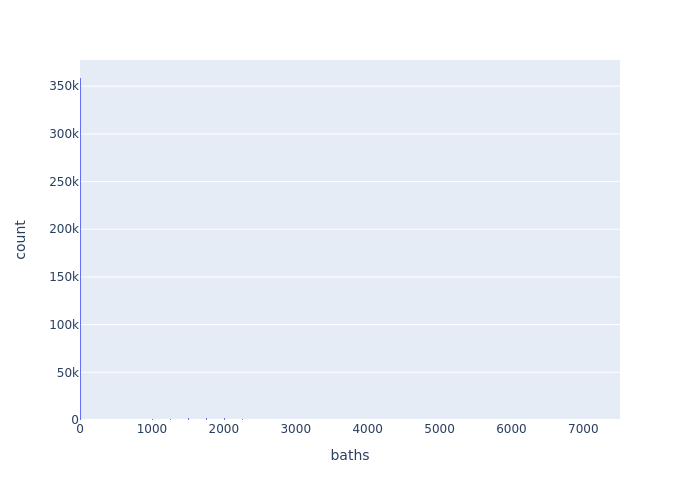

In [128]:
fig = px.histogram(df, x='baths')
fig.write_image('images/baths_histogram.png')
Image(filename='images/baths_histogram.png') 

Большая часть значений сконцентрировано возле 0. На графике видно длинный хвост справа из отдельных точек. Уберем выбросы при помощи методы Тьюки.

In [129]:
def outliers_iqr(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    
    outliers_filter = ''
    cleaned_filter = ''
    
    if left > 0:
        outliers_filter += '(x < lower_bound)'
        cleaned_filter += '(x >= lower_bound)'
    
    if right > 0:
        
        if outliers_filter != '':
            outliers_filter += ' | '
        outliers_filter += '(x > upper_bound)'
        
        if cleaned_filter != '':
            cleaned_filter += ' & '
        cleaned_filter += '(x <= upper_bound)'
        
    outliers = data[eval(outliers_filter)]
    cleaned = data[eval(cleaned_filter)]
    
    return outliers, cleaned

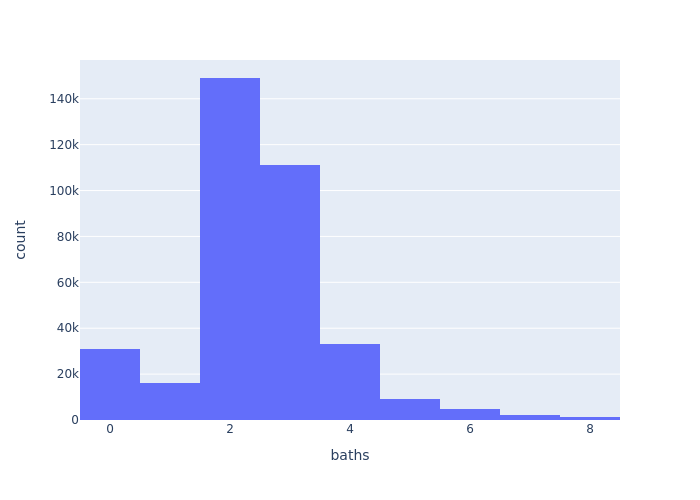

In [130]:
_, df_cleaned = outliers_iqr(df, 'baths', left=0, right=5)
fig = px.histogram(df_cleaned, x='baths')
fig.write_image('images/baths_cleaned_histogram.png')
Image(filename='images/baths_cleaned_histogram.png')

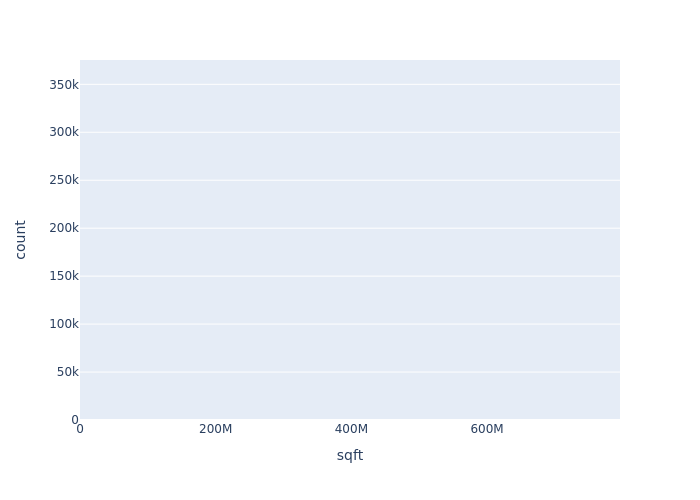

In [131]:
fig = px.histogram(df_cleaned, x='sqft')
fig.write_image('images/sqft_histogram.png')
Image(filename='images/sqft_histogram.png')

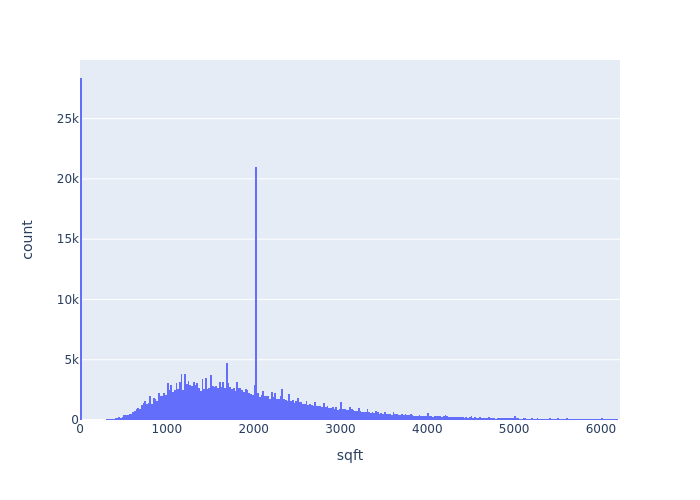

In [132]:
_, df_cleaned = outliers_iqr(df_cleaned, 'sqft', left=0, right=3)
fig = px.histogram(df_cleaned, x='sqft') 
fig.write_image('images/sqft_cleaned_histogram.png')
Image(filename='images/sqft_cleaned_histogram.png')

In [133]:
# из атрибута год реконструкции уберем строки со значениями меньше года постройки
df_cleaned = df_cleaned[~((df_cleaned['remodeled_year'] > 0) & (df_cleaned['remodeled_year'] < df_cleaned['year_built']))]

In [134]:
def transform_remodeled_year(row: pd.Series):
    if row['remodeled_year'] == 0:
        return 2022 - row['year_built']
    
    return 2022 - row['remodeled_year']

In [135]:
df_cleaned['remodeled_year'] = df_cleaned.apply(transform_remodeled_year, axis=1)

In [136]:
df_cleaned = df_cleaned[df_cleaned['year_built'] <= 2022]

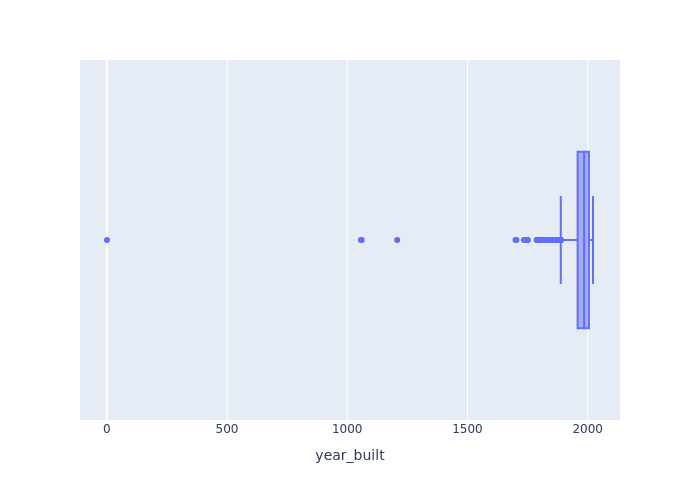

In [137]:
fig = px.box(df_cleaned, x='year_built')
fig.write_image('images/year_built_boxplot.png')
Image(filename='images/year_built_boxplot.png')

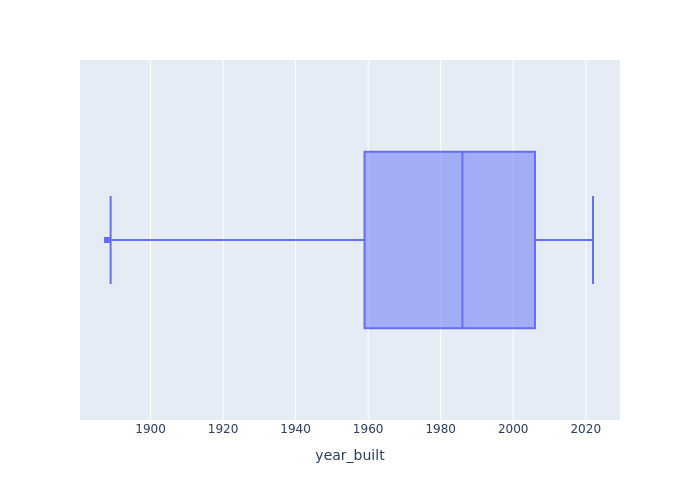

In [138]:
_, df_cleaned = outliers_iqr(df_cleaned, 'year_built', left=1.5, right=0)
fig = px.box(df_cleaned, x='year_built')
fig.write_image('images/year_built_cleaned_boxplot.png')
Image(filename='images/year_built_cleaned_boxplot.png')

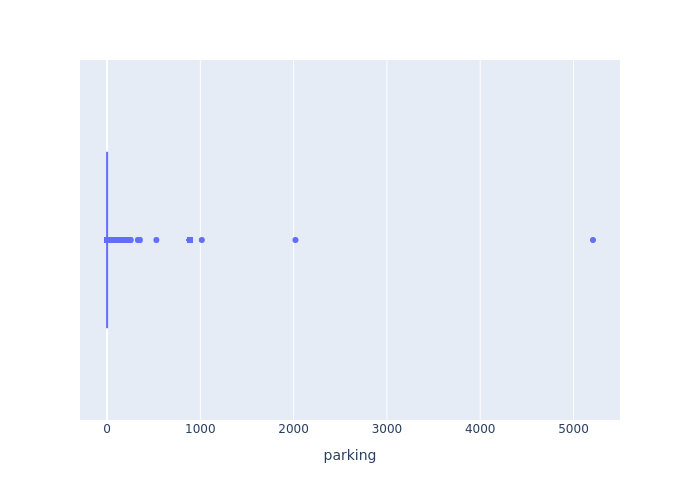

In [139]:
fig = px.box(df_cleaned, x='parking')
fig.write_image('images/parking_boxplot.png')
Image(filename='images/parking_boxplot.png')

In [140]:
df_cleaned['parking'].value_counts().head(15)

1.0      289698
2.0       30335
0.0       15824
3.0        4837
4.0        3238
6.0         816
5.0         673
8.0         234
888.0       232
7.0         153
10.0        115
9.0          67
12.0         38
20.0         25
11.0         19
Name: parking, dtype: int64

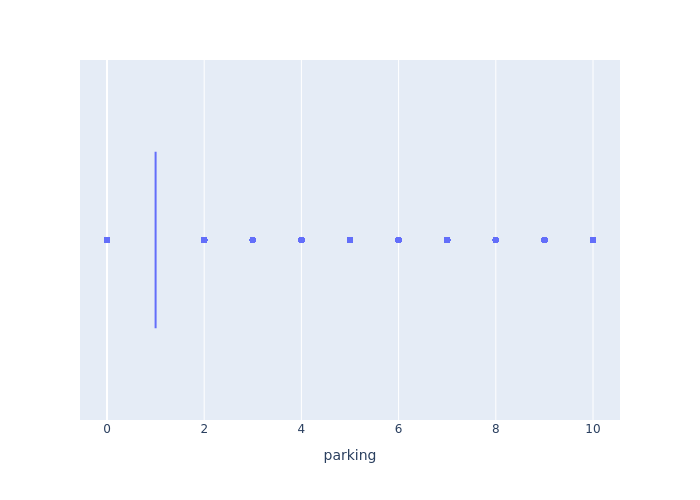

In [141]:
# у большей части собственности 10 или менее парковок. Оставим только эти данные, остальные будем считать за выбросы
df_cleaned = df_cleaned[df_cleaned['parking'] <= 10]
fig = px.box(df_cleaned, x='parking')
fig.write_image('images/parking_cleaned_boxplot.png')
Image(filename='images/parking_cleaned_boxplot.png')

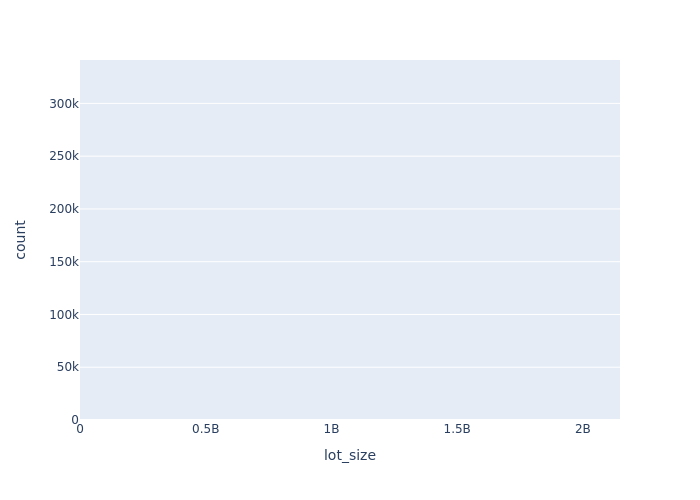

In [142]:
fig = px.histogram(df_cleaned, x='lot_size')
fig.write_image('images/lot_size_histogram.png')
Image(filename='images/lot_size_histogram.png')

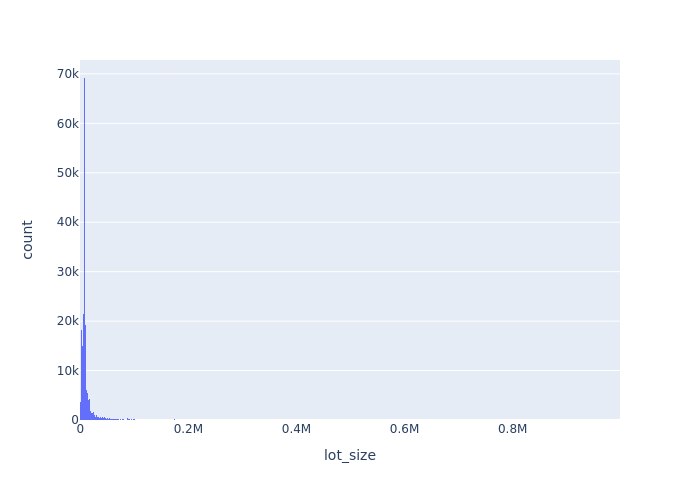

In [143]:
df_cleaned = df_cleaned[df_cleaned['lot_size'] <= 1000000]
fig = px.histogram(df_cleaned, x='lot_size')
fig.write_image('images/lot_size_cleaned_histogram.png')
Image(filename='images/lot_size_cleaned_histogram.png')

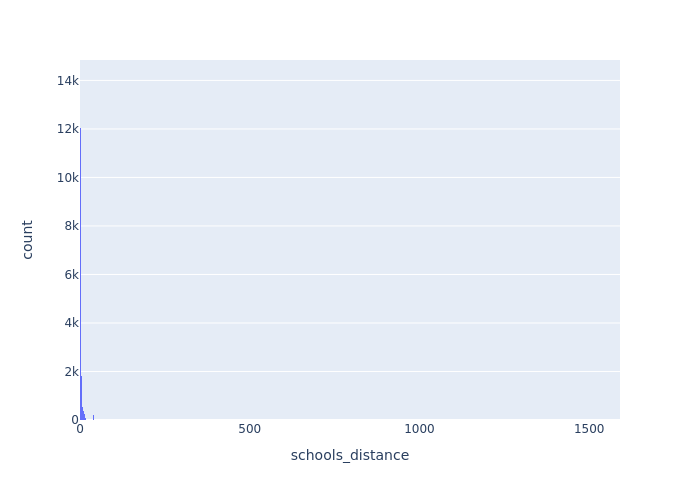

In [144]:
fig = px.histogram(df_cleaned, x='schools_distance')
fig.write_image('images/schools_distance_histogram.png')
Image(filename='images/schools_distance_histogram.png')

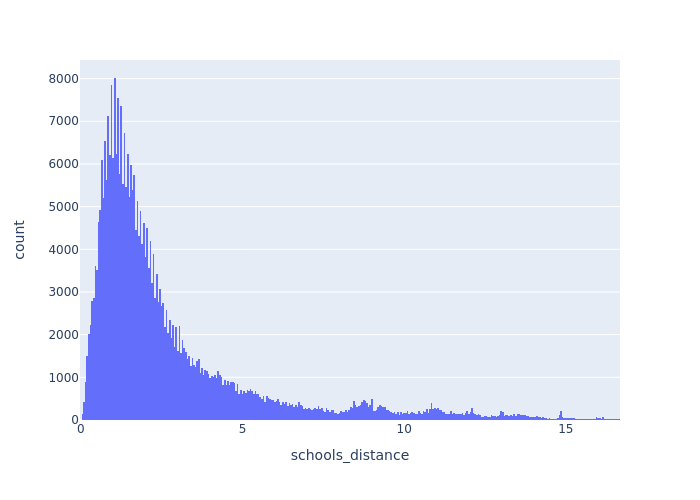

In [145]:
_, df_cleaned = outliers_iqr(df_cleaned, 'schools_distance', left=0, right=6)
fig = px.histogram(df_cleaned, x='schools_distance')
fig.write_image('images/schools_distance_cleaned_histogram.png')
Image(filename='images/schools_distance_cleaned_histogram.png')

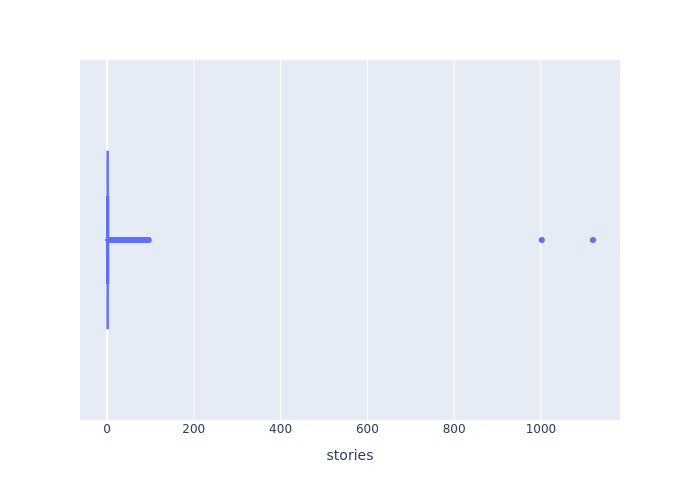

In [146]:
fig = px.box(df_cleaned, x="stories")
fig.write_image('images/stories_boxplot.png')
Image(filename='images/stories_boxplot.png')

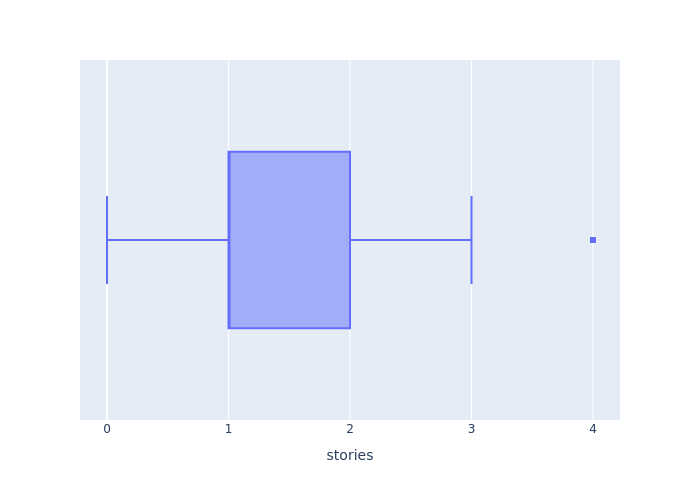

In [147]:
_, df_cleaned = outliers_iqr(df_cleaned, 'stories', left=0, right=2)
fig = px.box(df_cleaned, x="stories")
fig.write_image('images/stories_cleaned_boxplot.png')
Image(filename='images/stories_cleaned_boxplot.png')

##### Необходимо закодировать данные по категориальным признакам

In [148]:
df_cleaned.head(5)

,status,propertyType,baths,city,sqft,beds,state,stories,target,private_pool,remodeled_year,parking,heating,lot_size,cooling,year_built,schools_rating,schools_distance
0,active,single-family home,4.0,other,2900.0,4.0,NC,1.0,418000.0,0,3.0,1.0,central,8233.0,central,2019.0,5.200000,5.537500
1,for sale,single-family home,3.0,other,1947.0,3.0,WA,2.0,310000.0,0,3.0,1.0,forced,5828.0,central,2019.0,4.000000,1.326667
2,for sale,single-family home,2.0,los angeles,3000.0,3.0,CA,1.0,2895000.0,1,55.0,1.0,forced,8626.0,central,1961.0,6.666667,1.960000
4,for sale,land,0.0,palm bay,0.0,0.0,FL,1.0,5000.0,0,24.0,1.0,other,10019.0,central,1998.0,4.666667,4.080000
5,for sale,townhouse,3.0,philadelphia,897.0,3.0,PA,2.0,209000.0,0,102.0,1.0,forced,680.0,central,1920.0,2.000000,0.640000


In [149]:
encoder = ce.OneHotEncoder()
encoded = encoder.fit_transform(df_cleaned[['status', 'propertyType', 'heating', 'cooling']])
df_cleaned = df_cleaned.merge(encoded, left_index=True, right_index=True)

In [150]:
encoder = ce.BinaryEncoder()
encoded = encoder.fit_transform(df_cleaned[['city', 'state']])
df_cleaned = df_cleaned.merge(encoded, left_index=True, right_index=True)

In [151]:
df_cleaned = df_cleaned.drop(['status', 'propertyType', 'heating', 'cooling', 'city', 'state'], axis=1)

<AxesSubplot: >

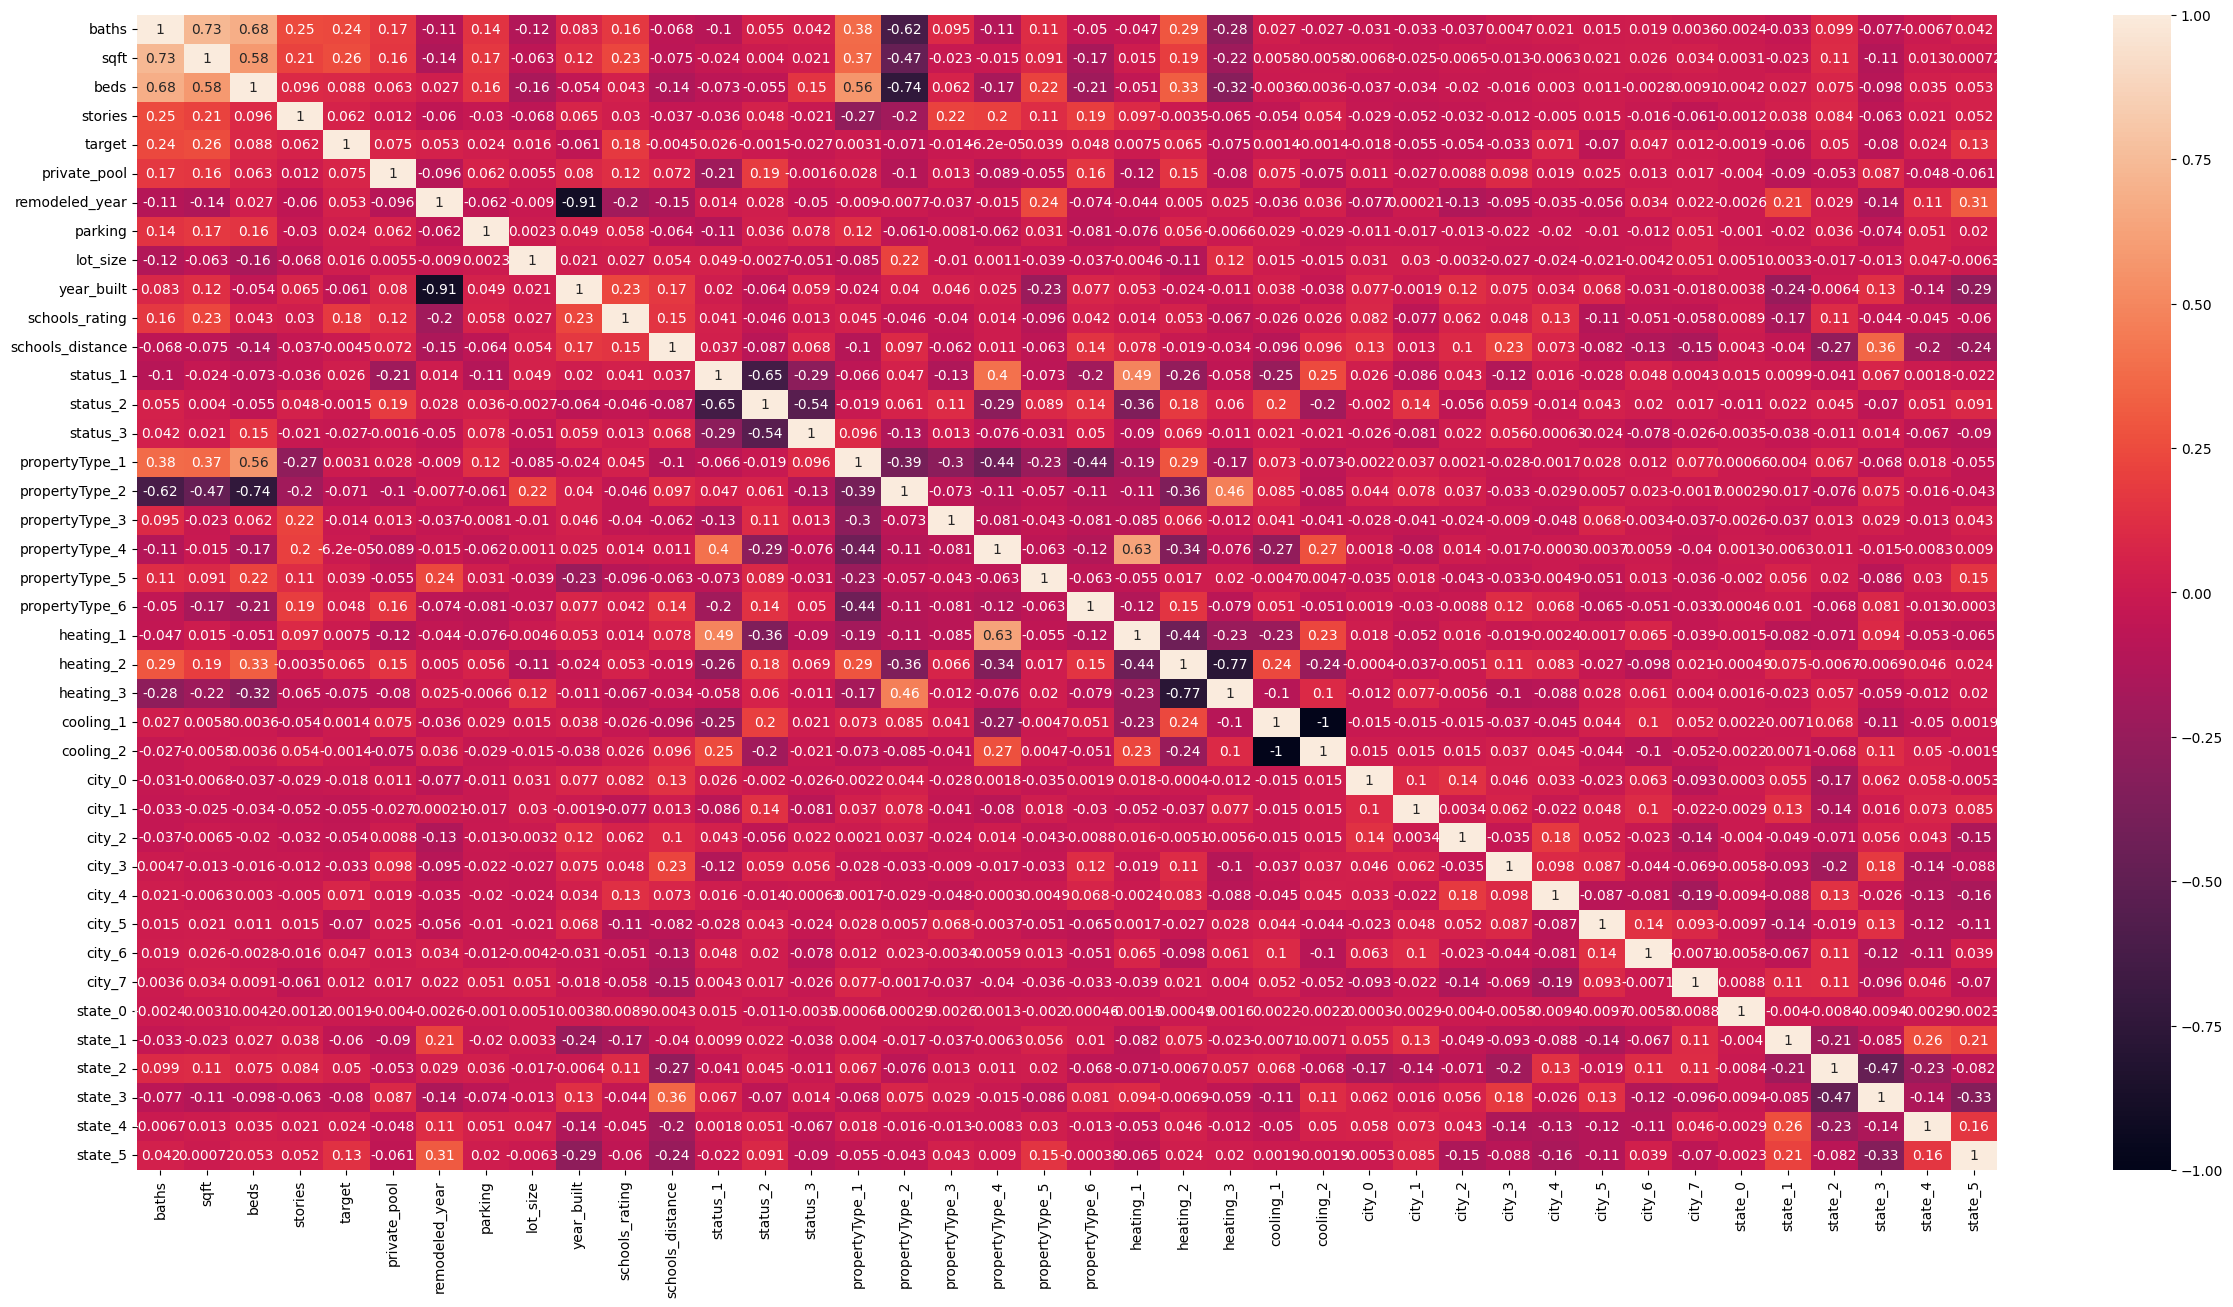

In [152]:
fig, ax = plt.subplots(figsize=(30,15)) 
sns.heatmap(df_cleaned.corr(), annot=True, ax=ax)

In [153]:
# уберем признаки с сильной корреляцией
df_cleaned = df_cleaned.drop(['year_built', 'cooling_2'], axis=1)

In [154]:
df_cleaned.to_csv('data/data_cleaned.csv', index=False)